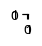

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180


# read/save full dataset for baseline (Kernel Sim and TBCRalign and tcrdist)

read tcrdist distance matrix from another notebook

In [27]:
old_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv').query('binder==1').reset_index(drop=True)
new_df = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv').query('binder==1').reset_index(drop=True)

In [ ]:
old_df['seq_id'] = range(len(old_df))
new_df['seq_id'] = range(len(new_df))
# saving split CDRs for tbcr_align
savecols = ['A1','A2','A3','B1','B2','B3', 'binder']
old_df.to_csv('../data/baselines/240415_nettcr_dataset_26peps_split_CDRs.tsv', sep='\t', columns=savecols,
              index=False, header=False)
new_df.to_csv('../data/baselines/240415_nettcr_dataset_140peps_split_CDRs.tsv', sep='\t', columns=savecols,
              index=False, header=False)
old_df['fulltcr'] = old_df['A1']+old_df['A2']+old_df['A3']+old_df['B1']+old_df['B2']+old_df['B3'] 
old_df['fulltcr'] = old_df['A1']+old_df['A2']+old_df['A3']+old_df['B1']+old_df['B2']+old_df['B3'] 

# fct defs

In [14]:
def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    # Extract the vae part if the model comes from a two stage VAE
    if type(model)==TwoStageVAECLF:
        model = model.vae
    model.eval()
    return model


def get_purity(counts):
    # Purity in absolute % of a cluster, taking the majority label 
    # high = better
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_counts[list(sorted_counts.keys())[0]] / sum(sorted_counts.values())
    
def get_mixity(counts):
    # how many different labels are inside a cluster, weighted by the number of members
    # low = better
    return len(counts.keys()) / sum(counts.values())
    
def get_coherence(dist_array):
    # Assumes dist_array is the subset of the distance array for a given cluster label
    # mean distance within a cluster
    # low = better

    # get upper triangle mask without the diagonale
    mask = np.triu(np.ones(dist_array.shape), k=0) - np.eye(dist_array.shape[0])
    flat_array = dist_array[mask==1]
    return np.mean(flat_array)

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

def get_all_metrics(t, features, c, array, true_labels, encoded_labels, label_encoder):
    n_cluster = np.sum((np.bincount(c.labels_)>1))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, array, label_encoder), index=[0])
                    for k in set(c.labels_)]).dropna()
    
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    nc_07 = len(xd.query('purity>=0.7'))
    return {'threshold':t, 
            'n_cluster':n_cluster, 'n_singletons':n_singletons,
            'n_cluster_over_70p':nc_07,
            'mean_purity':xd['purity'].mean(), 
            'min_purity':xd['purity'].min(), 
            'max_purity':xd['purity'].max(), 
            'mean_coherence':xd['coherence'].mean(), 
            'min_coherence':xd['coherence'].min(), 
            'max_coherence':xd['coherence'].max(), 
            'mean_cluster_size': xd['cluster_size'].mean(),
            'min_cluster_size': xd['cluster_size'].min(),
            'max_cluster_size': xd['cluster_size'].max(),
            'silhouette':s_score,
            'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score}

def get_bounds(array, decimals=5):
    lower_bound = array[array>0].min()
    upper_bound = array.max()
    factor = 10 ** decimals
    return np.floor(lower_bound * factor)/factor, np.ceil(upper_bound*factor)/factor


def get_linspace(array, decimals=5, n_points=1500):
    return np.round(np.linspace(*get_bounds(array, decimals), n_points), decimals)

In [15]:
def get_latent_df(model, df, dataset_params:dict=None):
    
    # Init dataset and pred fct depending on model type
    dataset_params = dict(max_len_a1=7, max_len_a2=8, max_len_a3=22,
                          max_len_b1=6, max_len_b2=7, max_len_b3=23, max_len_pep=0,
                          encoding='BL50LO', pad_scale=-20,
                          a1_col='A1', a2_col='A2', a3_col='A3', b1_col='B1', b2_col='B2', b3_col='B3',
                          pep_col='peptide') if dataset_params is None else dataset_params
    dataset_params['add_positional_encoding'] = model.add_positional_encoding
    
    if type(model) == FullTCRVAE:
        dataset = FullTCRDataset(df, **dataset_params)
        dataloader = dataset.get_dataloader(512, SequentialSampler)
        latent_df = predict_model(model, dataset, dataloader)
        
    elif type(model) in [BSSVAE, JMVAE]:
        pred_fct = predict_multimodal
        dataset_params['pair_only'] = True
        dataset_params['return_pair'] = type(model)==JMVAE
        dataset_params['modality']='tcr'
        dataset = MultimodalMarginalLatentDataset(model, df, **dataset_params)
        latent_df = df.copy()
        zdim = dataset.z.shape[1]
        latent_df[[f'z_{i}' for i in range(zdim)]] = dataset.z

    return latent_df

def get_distances_labels(latent_df, label_col='peptide', seq_cols= ('A1','A2','A3','B1','B2','B3')):
    # Columns for making distmatrix
    rest_cols = list(x for x in latent_df.columns if x in ['peptide', 'original_peptide','origin', 'binder'])
    # Getting distmatrix and arrays
    dist_matrix = make_dist_matrix(latent_df, label_col, seq_cols, cols=rest_cols)
    dist_array = dist_matrix.iloc[:, :-len(rest_cols)].values
    # Getting label encoder and features for computing metrics
    features = latent_df[[z for z in latent_df.columns if z.startswith('z_')]].values
    label_encoder = LabelEncoder()
    labels = latent_df[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

def cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder,
                           decimals=5, n_points=1500):
    # init params
    decimals = 5
    n_points = 1500
    # Getting clustering at all thresholds
    limits = get_linspace(dist_array, decimals, n_points)
    results = []
    for t in tqdm(limits):
        c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
        c.fit(dist_array)
        results.append(get_all_metrics(t, features, c, dist_array, labels, encoded_labels, label_encoder))
    results = pd.DataFrame(results)
    results['retention'] = (dist_array.shape[0]-results['n_singletons']) / dist_array.shape[0]
    return results

In [8]:
# Assuming we are using VAE based models 
model = get_model('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/', map_location='cpu')
df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv').query('binder==1')

Reloading best model:
Best epoch: 11882
total: 0.10637179474033316
reconstruction: 0.08248233795166016
kld: 0.0027784218546003103
triplet: 0.021111038426532353
seq_accuracy: 0.9905097484588623
pos_accuracy: 0.9976889491081238


In [9]:
top15peps = df.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index
df_top15 = df.query('peptide in @top15peps')

In [10]:
latent_df = get_latent_df(model, df_top15)

In [16]:
dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels(latent_df)
cos_results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [2:34:20<00:00,  6.17s/it]


In [ ]:
cos_results['input_type'] = 'Cos'

In [17]:
# Assuming we are using VAE based models 
model = get_model('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_KFold_0_LARGETCRP1/', map_location='cpu')
df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv').query('binder==1')

Reloading best model:
Best epoch: 11925
total: 0.35566675662994385
reconstruction: 0.34581807255744934
kld: 0.009848671965301037
triplet: 0.0
seq_accuracy: 0.9893524050712585
pos_accuracy: 0.9996309280395508


In [18]:
top15peps = df.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index
df_top15 = df.query('peptide in @top15peps')

In [19]:
latent_df = get_latent_df(model, df_top15)

In [20]:
dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels(latent_df)
ntr_results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [27:55<00:00,  1.12s/it]


In [21]:
ntr_results['input_type'] = 'Ntr'

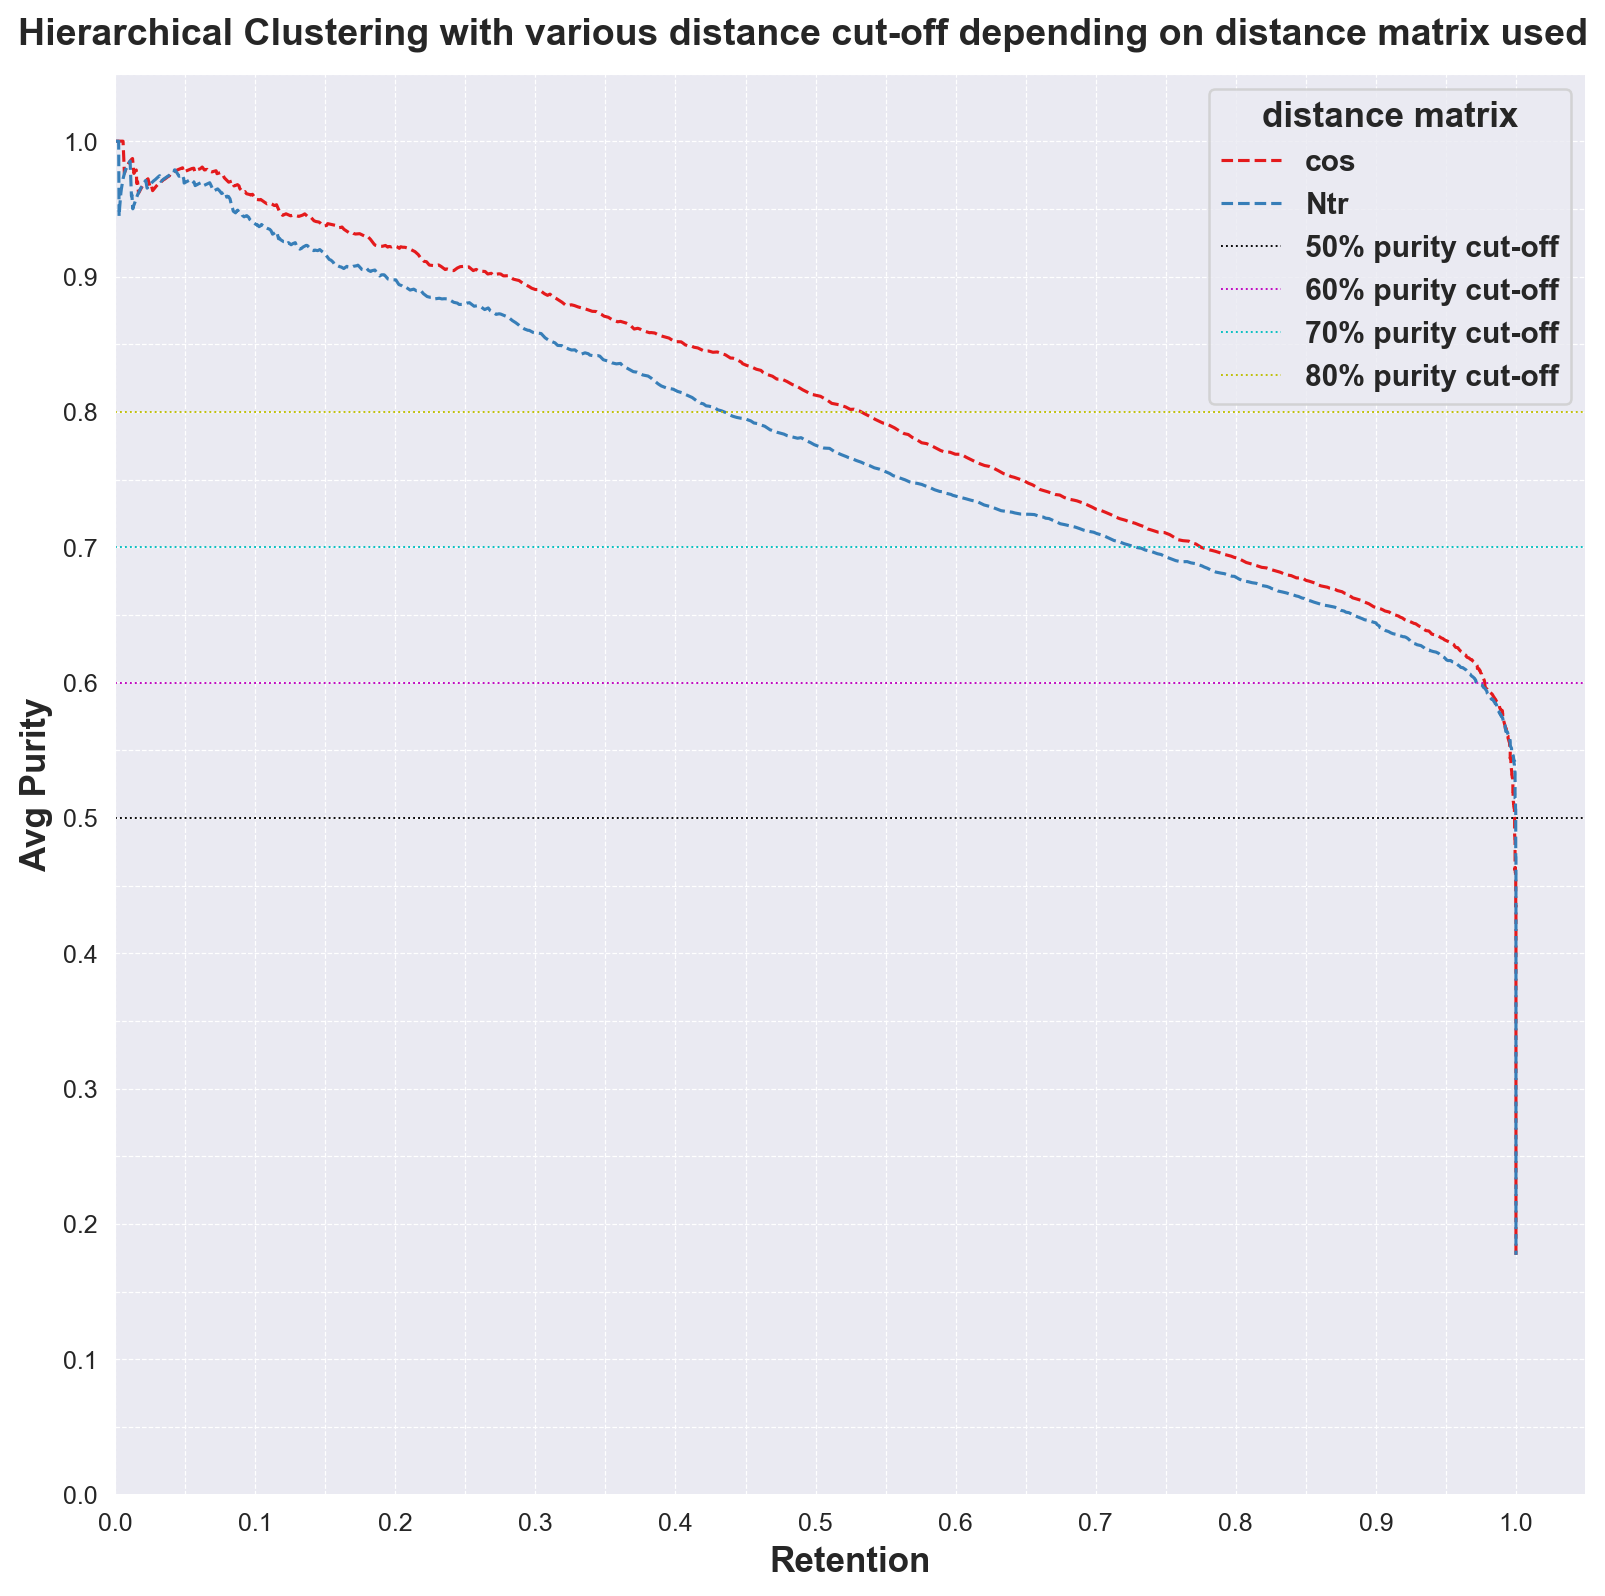

In [26]:
cat_results = pd.concat([cos_results.assign(input_type='cos').dropna(subset=['mean_purity']), ntr_results])
n_colors = len(cat_results.input_type.unique())
# plotting options
sns.set_palette('Set1', n_colors)
f,a = plt.subplots(1, 1, figsize=(9,9))
a.set_xlim([0,1])
a.set_ylim([0,1])
a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
# Setting major ticks
major_ticks = np.arange(0, 1.1, 0.1)
a.set_xticks(major_ticks)
a.set_yticks(major_ticks)
# Setting minor ticks
minor_ticks = np.arange(0, 1.1, 0.05)
a.set_xticks(minor_ticks, minor=True)
a.set_yticks(minor_ticks, minor=True)
plt.grid(which='both', linestyle='--', linewidth=0.5)

for input_type in cat_results.input_type.unique():
    query = cat_results.query('input_type==@input_type')
    retentions = query['retention'].values
    purities = query['mean_purity'].values
    a.plot(retentions, purities, label=input_type, ls='--', lw=1.25)

a.axhline(0.5, label='50% purity cut-off', ls=':', lw=.75, c='k')
a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')

a.legend(title='distance matrix', title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})
f.suptitle('Hierarchical Clustering with various distance cut-off depending on distance matrix used', fontweight='semibold', fontsize=15)
f.tight_layout()
# f.savefig('../output/240411_ClusteringTests/rp_curve.png', dpi=200)